## cdef class callback vs cython ode vs python ode

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from probDE.utils.utils import rand_mat
%load_ext cython

In [2]:
%%cython
from libc.math cimport sin
import numpy as np
cimport numpy as np

DTYPE = np.double
ctypedef np.double_t DTYPE_t

cdef class fun:
    cpdef np.ndarray[DTYPE_t, ndim=1] ode_fun(self, double[::1] x_t, double t, theta=None):
        return np.array([0])

cdef class odefun(fun):
    cpdef np.ndarray[DTYPE_t, ndim=1] odefun(self, double[::1] x_t, double t, theta=None):
        return np.array([sin(2*t) - x_t[0]])

In [3]:
from math import sin
def ode_py(x_t, t, theta=None):
    return np.array([sin(2*t) - x_t[0]])

In [4]:
%%cython
from libc.math cimport sin
import numpy as np
cimport numpy as np

DTYPE = np.double
ctypedef np.double_t DTYPE_t

cpdef np.ndarray[DTYPE_t, ndim=1] ode_cp(double[::1] x_t, double t, theta=None):
    return np.array([sin(2*t) - x_t[0]])

In [ ]:
x0_state = np.random.rand(4)
f = odefun()

In [ ]:
%timeit -o -n 100000 ode_py(x0_state, 0)

In [ ]:
%timeit -o -n 100000 ode_cp(x0_state, 0)

In [ ]:
%timeit -o -n 100000 f.odefun(x0_state, 0)

## KalmanODE & KalmanODE_py

In [5]:
from KalmanTest.KalmanODE_py import KalmanODE_py
from probDE.cython.KalmanTest.KalmanODE import KalmanODE

In [6]:
# These parameters define the order of the ODE and the CAR(p) process
n_meas = 1
n_state = 3

# it is assumed that the solution is sought on the interval [tmin, tmax].
n_steps = 50
n_eval = n_steps-1 # Number of grids points that are evaluated; in particular, the grid size delta = (U-L)*1/N
tmin = 0
tmax = 10

# The rest of the parameters can be tuned according to ODE
# For this problem, we will use
tau = 50
sigma = .001

# Initial value, a, for the IVP
w = np.array([0., 0., 1.])
x0 = np.array([-1., 0., 1.]) #Initial State
z_states = rand_mat(2*n_steps, n_state) #Random matrix

# Run the solver to get an approximation
kalmanode_py = KalmanODE_py(n_state, n_meas, tmin, tmax, n_eval, ode_py) # Initialize the class
x0_state = kalmanode_py.initialize(w, tau, sigma, x0) # Get the initial x0_state using initialize method
kalmanode_py.z_states = z_states # Set class z_states property as random matrix defined (can be omitted)
kalman_py_sim, kalman_py_mu, kalman_py_var, = kalmanode_py.solve(x0_state, mv=True, sim=True) # Run the solver

In [7]:
kalmanode = KalmanODE(n_state, n_meas, tmin, tmax, n_eval, ode_py) # Initialize the class
x0_state = kalmanode.initialize(w, tau, sigma, x0) # Get the initial x0_state using initialize method
kalmanode.z_states = z_states # Set class z_states property as random matrix defined (can be omitted)
kalman_sim, kalman_mu, kalman_var, = kalmanode.solve(x0_state, mv=True, sim=True)

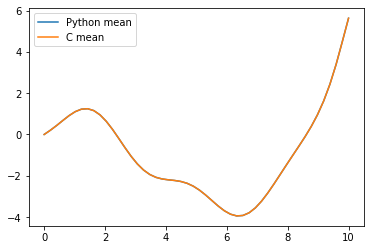

In [8]:
tseq = np.linspace(tmin, tmax, n_steps)
plt.plot(tseq, kalman_py_sim[:, 1], label = 'Python mean')
plt.plot(tseq, kalman_sim[:, 1], label = 'C mean')
plt.legend(loc='upper left')

In [9]:
kalman_cy = %timeit -o -n 100 _, _, _ = kalmanode.solve(x0_state, mv=True, sim=True)

327 µs ± 27 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [10]:
kalman_py = %timeit -o -n 100 _, _, _ = kalmanode_py.solve(x0_state, mv=True, sim=True)

12.7 ms ± 302 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [28]:
kalman_py.average/kalman_cy.average

38.97568757530194

## Lorenz63

In [11]:
def lorenz0(state, t):
    rho = 28.0
    sigma = 10.0
    beta = 8.0 / 3.0
    x, y, z = state  # Unpack the state vector
    return -sigma*x + sigma*y, rho*x - y -x*z, -beta*z + x*y

In [36]:
# RHS of ODE
def lorenz(X_t, t):
    rho = 28.0
    sigma = 10.0
    beta = 8.0 / 3.0
    p = 3
    x, y, z = X_t[p*0], X_t[p*1], X_t[p*2]
    return np.array([-sigma*x + sigma*y, rho*x - y -x*z, -beta*z + x*y]) 

# LHS Matrix of ODE
w_mat = np.array([[0.0, 1.0], [0.0, 1.0], [0.0, 1.0]])

# These parameters define the order of the ODE and the CAR(p) process
n_var = 3 # Number of variates
n_meas = 1 # ODE order
n_state = 3 # number of continuous derivatives of CAR(p) solution prior

# it is assumed that the solution is sought on the interval [L,U].
n_steps = 5000 # Number of grids points that are evaluated; in particular, the grid size delta = (U-L)*1/N
n_eval = n_steps -1
tmin = 0
tmax = 20

# The rest of the parameters can be tuned according to ODE
# For this problem, we will use
tau = 1
sigma = .001
sigmalst = [sigma]*n_var
scale = 10 # Scaling factor for root generation

# Initial value, a, for the IVP
x0 = [-12, -5, 38]
v0 = lorenz0(x0, 0)
a = np.array(list(zip(x0, v0)), dtype=np.double)
z_states = rand_mat(2*n_steps, n_var*n_state)

# Run the solver to get an approximation
kalmanode_py = KalmanODE_py(n_state, n_meas, tmin, tmax, n_eval, lorenz) # Initialize the class
x0_state = kalmanode_py.multi_initialize(w_mat, tau, sigmalst, scale, a) # Get the initial x0_state using initialize method
kalmanode_py.z_states = z_states # Set class z_states property as random matrix defined (can be omitted)
kalman_py_lor_sim, kalman_py_lor_mu, kalman_py_lor_var, = kalmanode_py.solve(x0_state, mv=True, sim=True) # Run the solver

In [37]:
kalmanode = KalmanODE(n_state, n_meas, tmin, tmax, n_eval, lorenz) # Initialize the class
x0_state = kalmanode.multi_initialize(w_mat, tau, sigmalst, scale, a) # Get the initial x0_state using initialize method
kalmanode.z_states = z_states # Set class z_states property as random matrix defined (can be omitted)
kalman_lor_sim, kalman_lor_mu, kalman_lor_var, = kalmanode.solve(x0_state, mv=True, sim=True)

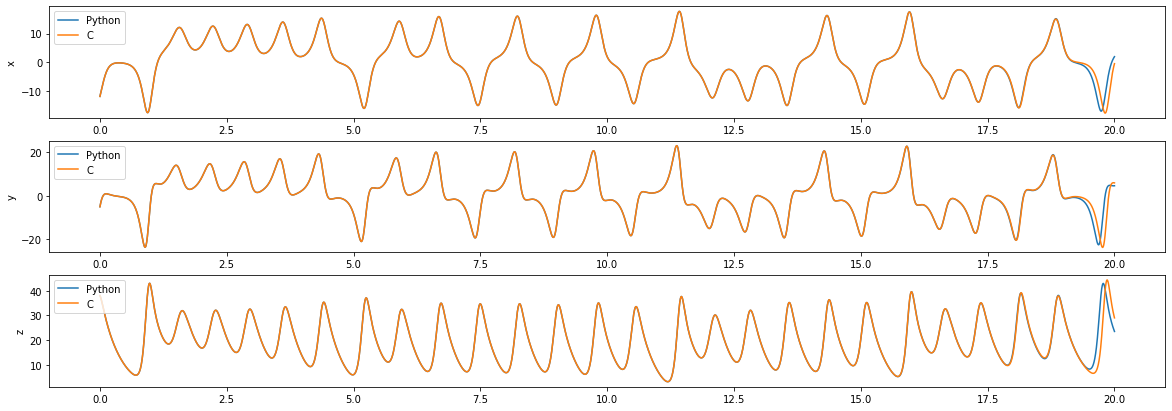

In [38]:
tseq = np.linspace(tmin, tmax, n_steps)
_, axs = plt.subplots(n_var, 1, figsize=(20, 7))
ylabel = ['x', 'y', 'z']
for i in range(n_var):
    axs[i].plot(tseq, kalman_py_lor_sim[:, n_state*i], label="Python")
    axs[i].plot(tseq, kalman_lor_sim[:, n_state*i], label="C")
    axs[i].set_ylabel(ylabel[i])
    axs[i].legend(loc='upper left')

In [39]:
kalman_lor_cy = %timeit -o _ = kalmanode.solve(x0_state, mv=True, sim=True)

192 ms ± 3.26 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [40]:
kalman_lor_py = %timeit -o _, _, _ = kalmanode_py.solve(x0_state, mv=True, sim=True)

3.13 s ± 40.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [41]:
kalman_lor_py.average/kalman_lor_cy.average

16.329384335544326

## Lane-Emden

In [21]:
from scipy.integrate import odeint
def lane0(x_t, t):
    return [x_t[1], -2/t*x_t[1] - x_t[0]]

In [18]:
def lane(x_t, t):
    return np.array([-2/t*x_t[1] - x_t[0]])

# These parameters define the order of the ODE and the CAR(p) process
n_meas = 1
n_state = 3

# it is assumed that the solution is sought on the interval [tmin, tmax].
n_steps = 500
n_eval = n_steps-1 # Number of grids points that are evaluated; in particular, the grid size delta = (U-L)*1/N
tmin = 1
tmax = 10

# The rest of the parameters can be tuned according to ODE
# For this problem, we will use
tau = 50
sigma = .001

# Initial value, a, for the IVP
w = np.array([0., 0., 1.])
x0 = np.array([1., 0., -1.]) #Initial State
z_states = rand_mat(2*n_steps, n_state) #Random matrix

# Run the solver to get an approximation
kalmanode_py = KalmanODE_py(n_state, n_meas, tmin, tmax, n_eval, lane) # Initialize the class
x0_state = kalmanode_py.initialize(w, tau, sigma, x0) # Get the initial x0_state using initialize method
kalmanode_py.z_states = z_states # Set class z_states property as random matrix defined (can be omitted)
kalman_py_lane_sim, kalman_py_lane_mu, kalman_py_lane_var, = kalmanode_py.solve(x0_state, mv=True, sim=True) # Run the solver

In [19]:
kalmanode = KalmanODE(n_state, n_meas, tmin, tmax, n_eval, lane) # Initialize the class
x0_state = kalmanode.initialize(w, tau, sigma, x0) # Get the initial x0_state using initialize method
kalmanode.z_states = z_states # Set class z_states property as random matrix defined (can be omitted)
kalman_lane_sim, kalman_lane_mu, kalman_lane_var, = kalmanode.solve(x0_state, mv=True, sim=True)

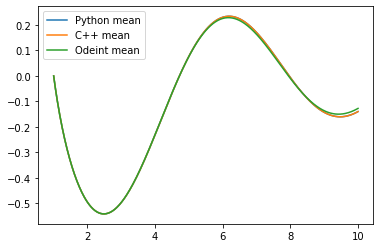

In [22]:
tseq = np.linspace(tmin, tmax, n_steps)
lane_odeint = odeint(lane0, [1, 0], tseq)
plt.plot(tseq, kalman_py_lane_sim[:, 1], label = 'Python mean')
plt.plot(tseq, kalman_lane_sim[:, 1], label = 'C++ mean')
plt.plot(tseq, lane_odeint[:, 1], label = 'Odeint mean')
plt.legend(loc='upper left')

In [23]:
kalman_lane_cy = %timeit -o _ = kalmanode.solve(x0_state, mv=True, sim=True)

2.93 ms ± 28.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [24]:
kalman_lane_py = %timeit -o _, _, _ = kalmanode_py.solve(x0_state, mv=True, sim=True)

130 ms ± 2.78 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [26]:
kalman_lane_py.average/kalman_lane_cy.average

44.45654272427814